In [ ]:
!gdown 1f7WAwkuTFgLzCCTs2HZv3AmtBkET4l1M

Downloading...
From: https://drive.google.com/uc?id=1f7WAwkuTFgLzCCTs2HZv3AmtBkET4l1M
To: /content/sem_eval_2018.zip
100% 662k/662k [00:00<00:00, 85.7MB/s]


In [ ]:
!unzip /content/sem_eval_2018.zip

Archive:  /content/sem_eval_2018.zip
replace sem_eval_2018/val.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: sem_eval_2018/val.csv   
replace sem_eval_2018/test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: sem_eval_2018/test.csv  
replace sem_eval_2018/train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: sem_eval_2018/train.csv  


In [ ]:
!pip install unidecode

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras

In [ ]:
train_df = pd.read_csv('/content/sem_eval_2018/train.csv')
val_df = pd.read_csv('/content/sem_eval_2018/val.csv')
test_df = pd.read_csv('/content/sem_eval_2018/test.csv')

In [ ]:
train_df.keys()

Index(['Unnamed: 0', 'ID', 'Tweet', 'anger', 'anticipation', 'disgust', 'fear',
       'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust'],
      dtype='object')

In [ ]:
import numpy as np

classes_name = np.array(train_df.columns[3:])

n_classes = len(classes_name)

n_samples = train_df.shape[0] + test_df.shape[0] + val_df.shape[0]

print(classes_name)
print(n_classes)
print(n_samples)

['anger' 'anticipation' 'disgust' 'fear' 'joy' 'love' 'optimism'
 'pessimism' 'sadness' 'surprise' 'trust']
11
10983


In [ ]:
import re 
import nltk
import unidecode

nltk.download('stopwords')

from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

english_stop_words = stopwords.words('english')
stemmer = PorterStemmer()

def text_normalize(text):
  text = text.lower()
  text = unidecode.unidecode(text)
  text = text.strip()
  text = re.sub('[^\w\s]','', text)
  text = ' '.join([word for word in text.split(' ') if word not in english_stop_words])
  text = ' '.join([stemmer.stem(word) for word in text.split(' ')])
  return text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
train_df['Tweet'] = train_df['Tweet'].apply(lambda p: text_normalize(p)).astype(str)
test_df['Tweet'] = test_df['Tweet'].apply(lambda p: text_normalize(p)).astype(str)
val_df['Tweet'] = val_df['Tweet'].apply(lambda p: text_normalize(p)).astype(str)

In [ ]:
X_train = train_df['Tweet'].to_numpy()
y_train = train_df[classes_name].astype('int').to_numpy()

X_val = val_df['Tweet'].to_numpy()
y_val = val_df[classes_name].astype('int').to_numpy()

X_test = test_df['Tweet'].to_numpy()
y_test = test_df[classes_name].astype('int').to_numpy()

In [ ]:
BATCH_SIZE=128

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).cache().batch(BATCH_SIZE)
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).cache().batch(BATCH_SIZE)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).cache().batch(BATCH_SIZE)

In [ ]:
type(train_ds)

tensorflow.python.data.ops.dataset_ops.PrefetchDataset

In [ ]:
def inverse_label(class_lst, onehot_label):

    return class_lst[onehot_label > 0]

for text_batch, label_batch in train_ds.take(1):
  for i in range(10):
    print("Text: ", text_batch.numpy()[i])
    print("Label:", inverse_label(classes_name, label_batch.numpy()[i]))

Text:  b'worri payment problem may never  joyc meyer  motiv leadership worri'
Label: ['anticipation' 'optimism' 'trust']
Text:  b'whatev decid make sure make happi'
Label: ['joy' 'love' 'optimism']
Text:  b'max_kellerman  also help major nfl coach inept bill obrien play call wow  gopat'
Label: ['anger' 'disgust' 'joy' 'optimism']
Text:  b'accept challeng liter even feel exhilar victori  georg patton'
Label: ['joy' 'optimism']
Text:  b'roommat okay cant spell autocorrect terribl firstworldprob'
Label: ['anger' 'disgust']
Text:  b'that cute atsu probabl shi photo cherri help uwu'
Label: ['joy']
Text:  b'think human sens recogn impend doom'
Label: ['anticipation' 'pessimism']
Text:  b'rooney fuck untouch isnt fuck dread depay look decentishtonight'
Label: ['anger' 'disgust']
Text:  b'pretti depress u hit pan ur favourit highlight'
Label: ['disgust' 'sadness']
Text:  b'bossupjae pussi weak heard stfu bitch  got threaten pregnant '
Label: ['anger' 'disgust']


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
MAX_SEQ_LEN = 128
MAX_FEATURES = 5000
EMBEDDING_DIMS = 64

text_vectorization_layer = tf.keras.layers.TextVectorization(
    max_tokens=MAX_FEATURES, 
    output_mode='int', 
    output_sequence_length=MAX_SEQ_LEN, 
    name='vectorization_layer'
)

train_text = train_ds.map(lambda text, label: text)
text_vectorization_layer.adapt(train_text)

In [ ]:
model = keras.Sequential()
model.add(keras.Input(shape=(1, ), dtype='string', name='input_layer'))

model.add(text_vectorization_layer)
model.add(keras.layers.Embedding(MAX_FEATURES + 1, EMBEDDING_DIMS, name='embedding_layer'))

model.add(keras.layers.Bidirectional(keras.layers.LSTM(64, return_sequences=True), name='bi_lstm_layer_1'))
model.add(keras.layers.Bidirectional(keras.layers.LSTM(64, return_sequences=True), name='bi_lstm_layer_2'))
model.add(keras.layers.Bidirectional(keras.layers.LSTM(64, return_sequences=False), name='bi_lstm_layer_3'))

model.add(keras.layers.Dropout(0.2, name='dropout_layer_1'))
model.add(keras.layers.Dense(64, activation='relu', name='fl_layer_1'))

model.add(keras.layers.Dropout(0.3, name='dropout_layer_2'))
model.add(keras.layers.Dense(32, activation='relu', name='fl_layer_2'))

model.add(keras.layers.Dropout(0.3, name='dropout_layer_3'))
model.add(keras.layers.Dense(11, activation='sigmoid', name='output_layer'))
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vectorization_layer (TextVe  (None, 128)              0         
 ctorization)                                                    
                                                                 
 embedding_layer (Embedding)  (None, 128, 64)          320064    
                                                                 
 bi_lstm_layer_1 (Bidirectio  (None, 128, 128)         66048     
 nal)                                                            
                                                                 
 bi_lstm_layer_2 (Bidirectio  (None, 128, 128)         98816     
 nal)                                                            
                                                                 
 bi_lstm_layer_3 (Bidirectio  (None, 128)              98816     
 nal)                                                 

In [ ]:
model.compile(
    optimizer = keras.optimizers.Adam(learning_rate=1e-4), 
    loss = keras.losses.BinaryCrossentropy(), 
    metrics=['accuracy']
)

record = model.fit(train_ds,
                   validation_data = val_ds, 
                   epochs=30, 
                   verbose=2)

Epoch 1/30
54/54 - 18s - loss: 0.6567 - accuracy: 0.0481 - val_loss: 0.5636 - val_accuracy: 0.0147 - 18s/epoch - 328ms/step
Epoch 2/30
54/54 - 2s - loss: 0.5861 - accuracy: 0.0915 - val_loss: 0.5211 - val_accuracy: 0.0147 - 2s/epoch - 45ms/step
Epoch 3/30
54/54 - 2s - loss: 0.5626 - accuracy: 0.1261 - val_loss: 0.5070 - val_accuracy: 0.0147 - 2s/epoch - 44ms/step
Epoch 4/30
54/54 - 2s - loss: 0.5522 - accuracy: 0.1353 - val_loss: 0.5014 - val_accuracy: 0.0327 - 2s/epoch - 44ms/step
Epoch 5/30
54/54 - 2s - loss: 0.5440 - accuracy: 0.1454 - val_loss: 0.4998 - val_accuracy: 0.2754 - 2s/epoch - 44ms/step
Epoch 6/30
54/54 - 2s - loss: 0.5369 - accuracy: 0.1454 - val_loss: 0.4923 - val_accuracy: 0.0767 - 2s/epoch - 43ms/step
Epoch 7/30
54/54 - 2s - loss: 0.5307 - accuracy: 0.1508 - val_loss: 0.4881 - val_accuracy: 0.1072 - 2s/epoch - 43ms/step
Epoch 8/30
54/54 - 2s - loss: 0.5267 - accuracy: 0.1492 - val_loss: 0.4874 - val_accuracy: 0.1670 - 2s/epoch - 43ms/step
Epoch 9/30
54/54 - 2s - loss:

In [ ]:
test_evaluation = model.evaluate(test_ds)

26/26 [==============================] - 1s 25ms/step - loss: 0.4163 - accuracy: 0.4498


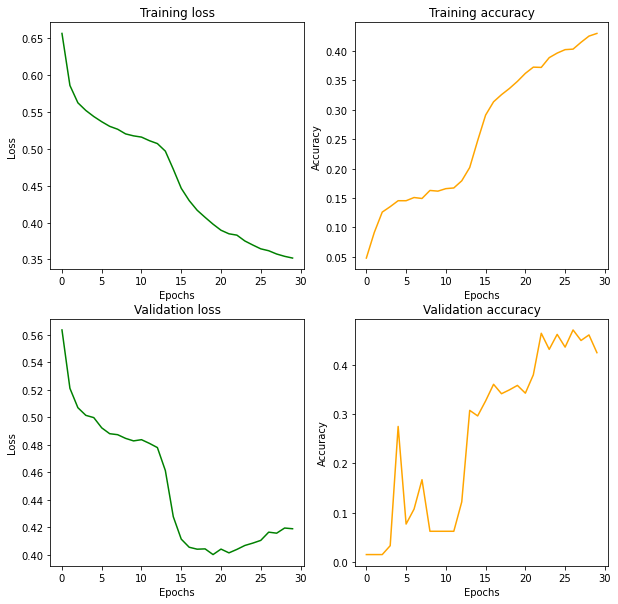

In [ ]:

train_loss, train_acc = record.history['loss'], record.history['accuracy'] 
val_loss, val_acc = record.history['val_loss'], record.history['val_accuracy'] 
plt.figure(figsize=(10, 10)

plt.subplot(2, 2, 1)
plt.xlabel('Epochs') 
plt.ylabel('Loss')
plt.title('Training loss') 
plt.plot(train_loss, color='green')

plt.subplot(2, 2, 2) 
plt.xlabel('Epochs') 
plt.ylabel('Accuracy') 
plt.title('Training accuracy') 
plt.plot(train_acc, color='orange')

plt.subplot(2, 2, 3) 
plt.xlabel('Epochs') 
plt.ylabel('Loss')
plt.title('Validation loss') 
plt.plot(val_loss, color='green') 

plt.subplot(2, 2, 4)
plt.xlabel('Epochs')
plt.ylabel('Accuracy') 
plt.title('Validation accuracy') 
plt.plot(val_acc, color='orange') 

plt.show() 

In [ ]:
threshold = 0.4

for text_batch, label_batch in test_ds.take(1):
    for i in range(10):
        input_text = text_batch[i].numpy()
        label = label_batch[i].numpy()
        pred = model.predict(np.expand_dims(input_text, 0), verbose=0)[0]
        threshold_pred = np.where(pred > threshold, 1, 0)
        print(f"Text: {input_text}")
        print(f"Label: {inverse_label(classes_name, label)}")
        print(f"Predicted Label(s): ({inverse_label(classes_name, threshold_pred)})")
        print(" ")

Text: b'adnan__786__ asyounotwish dont worri indian armi way dispatch terrorist hell'
Label: ['anger' 'anticipation' 'optimism' 'trust']
Predicted Label(s): (['anger' 'disgust' 'fear' 'sadness'])
 
Text: b'academi scienc eschew normal sober tone scientif paper call massiv loss wildlif biolog annihil'
Label: ['disgust']
Predicted Label(s): (['joy'])
 
Text: b'blew opportun __ mad'
Label: ['anger' 'disgust' 'sadness']
Predicted Label(s): (['sadness'])
 
Text: b'time 2 week 30'
Label: ['joy' 'sadness']
Predicted Label(s): (['sadness'])
 
Text: b'deppress real partner w depress peopl truli dont understand depth affect us add anxieti ampmak wors'
Label: ['fear' 'sadness']
Predicted Label(s): (['anger' 'disgust' 'fear' 'sadness'])
 
Text: b'politicoeurop interest choic word confirm govern fund terror bit open door still'
Label: ['anger' 'disgust' 'fear' 'pessimism']
Predicted Label(s): (['anger' 'disgust' 'sadness'])
 
Text: b'ananavarro cnn sure'
Label: ['joy' 'optimism']
Predicted Label(s)